# Image / Video - Segmentation

# Imports

In [ ]:
import torch
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from torchvision import transforms
from collections import Counter

# Load pre-trained model

In [ ]:
# Download checkpoint from: 
# https://huggingface.co/facebook/sam2-hiera-large/resolve/main/sam2_hiera_large.pt

In [ ]:
# Load a pre-trained DeepLabV3 model from torchvision
model = torch.hub.load('pytorch/vision:v0.10.0', 'deeplabv3_resnet101', pretrained=True)
model.eval()

In [ ]:
# Define a transformation pipeline to normalize the input image - hard coded numbers come from model normalization
preprocess = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [ ]:
# Map of class labels for PASCAL VOC
voc_labels = {
    0: 'background', 1: 'aeroplane', 2: 'bicycle', 3: 'bird', 4: 'boat', 5: 'bottle',
    6: 'bus', 7: 'car', 8: 'cat', 9: 'chair', 10: 'cow', 11: 'dining table',
    12: 'dog', 13: 'horse', 14: 'motorbike', 15: 'person', 16: 'potted plant',
    17: 'sheep', 18: 'sofa', 19: 'train', 20: 'TV monitor'
}

# Define pipeline

In [ ]:
# Load the image
image_path = "data/test.jpg"  # Change to your image path
input_image = Image.open(image_path).convert("RGB")
input_tensor = preprocess(input_image).unsqueeze(0)  # Add batch dimension

# Perform the forward pass to get the segmentation output
with torch.no_grad():
    output = model(input_tensor)['out'][0]
output_predictions = output.argmax(0)  # Get the most likely class for each pixel

# Get the segmentation colors (for visualization)
def decode_segmap(segmentation, num_classes=21):
    # Define the color map (21 classes based on PASCAL VOC)
    label_colors = np.array([(0, 0, 0),  # background
                             (128, 0, 0),  # aeroplane
                             (0, 128, 0),  # bicycle
                             (128, 128, 0),  # bird
                             (0, 0, 128),  # boat
                             (128, 0, 128),  # bottle
                             (0, 128, 128),  # bus
                             (0, 255, 0),  # car
                             (64, 0, 0),  # cat
                             (192, 0, 0),  # chair
                             (64, 128, 0),  # cow
                             (192, 128, 0),  # dining table
                             (64, 0, 128),  # dog
                             (192, 0, 128),  # horse
                             (64, 128, 128),  # motorbike
                             (255, 0, 0),  # person
                             (0, 64, 0),  # potted plant
                             (128, 64, 0),  # sheep
                             (0, 192, 0),  # sofa
                             (128, 192, 0),  # train
                             (0, 64, 128)])  # TV monitor

    r = np.zeros_like(segmentation).astype(np.uint8)
    g = np.zeros_like(segmentation).astype(np.uint8)
    b = np.zeros_like(segmentation).astype(np.uint8)

    for l in range(0, num_classes):
        idx = segmentation == l
        r[idx] = label_colors[l, 0]
        g[idx] = label_colors[l, 1]
        b[idx] = label_colors[l, 2]

    rgb = np.stack([r, g, b], axis=2)
    return rgb

# Decode segmentation map
segmentation_map = decode_segmap(output_predictions.cpu().numpy())

# Overlay segmentation on the original image
segmentation_overlay = Image.blend(input_image, Image.fromarray(segmentation_map), alpha=0.5)

# Plot results

Using cache found in /Users/alexc/.cache/torch/hub/pytorch_vision_v0.10.0


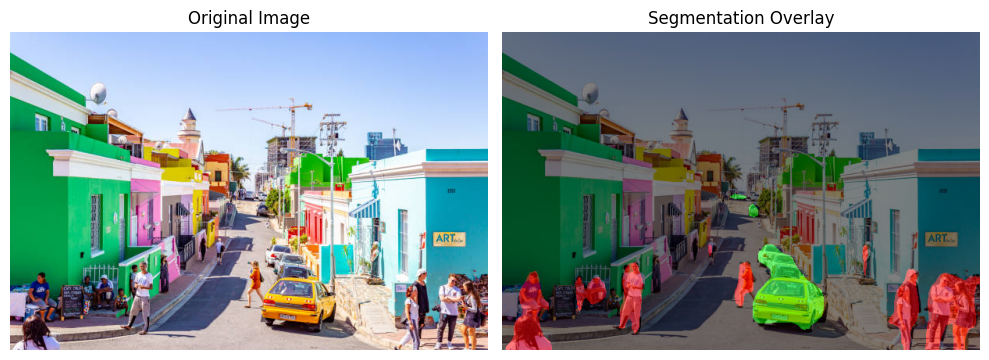

6541 pixels of type car
14417 pixels of type person


In [ ]:
# Plot the original image and the segmentation overlay
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(input_image)
plt.axis('off')
plt.title('Original Image')

plt.subplot(1, 2, 2)
plt.imshow(segmentation_overlay)
plt.axis('off')
plt.title('Segmentation Overlay')

plt.tight_layout()
plt.show()

# Count the number of each object type in the segmentation map
unique_labels, counts = np.unique(output_predictions.cpu().numpy(), return_counts=True)
label_counts = dict(zip(unique_labels, counts))

# Print out the objects and their counts
object_counts = {}
for label, count in label_counts.items():
    if label != 0:  # Ignore background
        label_name = voc_labels.get(label, "unknown")
        object_counts[label_name] = count

# Print object list
for object_type, count in object_counts.items():
    print(f"{count} pixels of type {object_type}")

# Background Replacement

Using cache found in /Users/alexc/.cache/torch/hub/pytorch_vision_v0.10.0


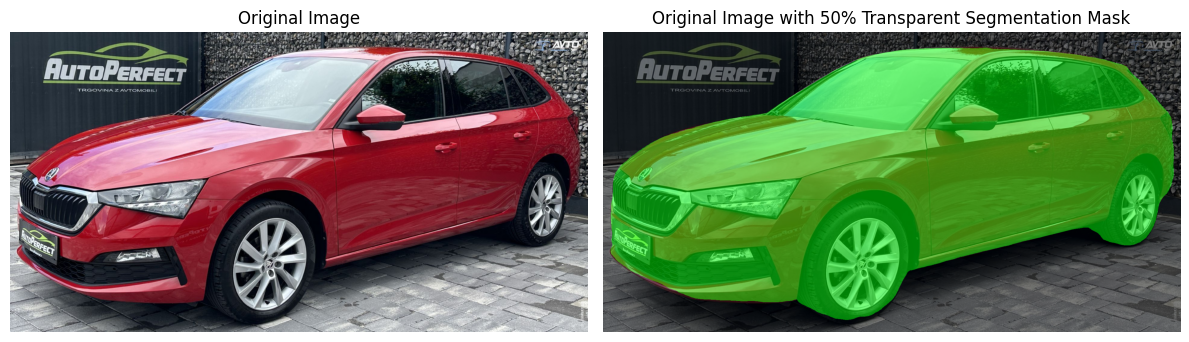

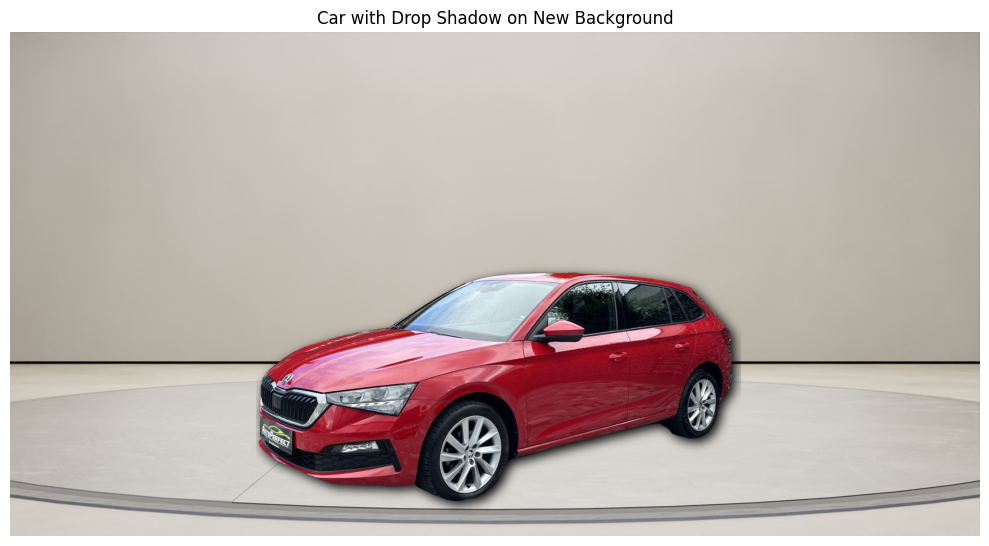

In [67]:
import torch
from PIL import Image, ImageFilter, ImageDraw
import numpy as np
from torchvision import transforms
import matplotlib.pyplot as plt

# Load the pre-trained DeepLabV3 model from torchvision
model = torch.hub.load('pytorch/vision:v0.10.0', 'deeplabv3_resnet101', pretrained=True)
model.eval()

# Define a transformation pipeline to normalize the input image
preprocess = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Load the original image with the car and the background image
image_path = 'data/car.jpg'  # Car image
background_path = 'data/car_bg.jpeg'  # New background image

input_image = Image.open(image_path).convert("RGB")
background_image = Image.open(background_path).convert("RGB")

# Preprocess the input image
input_tensor = preprocess(input_image).unsqueeze(0)

# Perform the forward pass to get the segmentation output
with torch.no_grad():
    output = model(input_tensor)['out'][0]
output_predictions = output.argmax(0)  # Get the most likely class for each pixel

# Create a binary mask for the "car" class (class label 7 in PASCAL VOC)
car_class = 7  # Class label for "car" in PASCAL VOC
car_mask = output_predictions == car_class

# Create an RGB segmentation map with the car mask in green
segmentation_map = np.zeros((input_image.size[1], input_image.size[0], 3), dtype=np.uint8)
segmentation_map[car_mask.cpu().numpy()] = [0, 255, 0]  # Green for the car

# Convert the segmentation map to an image
segmentation_map_pil = Image.fromarray(segmentation_map)

# Blend the original image with the segmentation map with 50% transparency
segmentation_overlay = Image.blend(input_image, segmentation_map_pil, alpha=0.5)

# Plot the original image and the image with the segmentation mask overlay
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.imshow(input_image)
plt.title("Original Image")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(segmentation_overlay)
plt.title("Original Image with 50% Transparent Segmentation Mask")
plt.axis("off")

plt.tight_layout()
plt.show()

# ---- Drop shadow and compositing ---- #

# Convert the mask to a PIL image
car_mask_pil = Image.fromarray(car_mask.cpu().numpy().astype(np.uint8) * 255)

# Crop the car from the original image using the mask
car_cutout = Image.composite(input_image, Image.new("RGB", input_image.size), car_mask_pil)

# Resize the car to 50% of its original width
original_width, original_height = car_cutout.size
new_width = int(original_width * 0.50)
new_height = int((new_width / original_width) * original_height)
car_cutout_resized = car_cutout.resize((new_width, new_height), Image.Resampling.LANCZOS)

# Resize the car mask to match the new car size
car_mask_resized = car_mask_pil.resize((new_width, new_height), Image.Resampling.LANCZOS)

# Create a drop shadow
shadow_offset = (7, 7)  # Offset for the shadow (bottom right)
blur_radius = 10  # The radius of the blur for the shadow

# Create the shadow by filling the car mask with black
shadow = Image.new("RGBA", car_cutout_resized.size, (0, 0, 0, 255))  # Solid black shadow
shadow_mask = car_mask_resized.copy().convert("L")  # Convert mask to grayscale

# Apply the shadow mask to the black image
shadow_with_mask = Image.composite(shadow, Image.new("RGBA", car_cutout_resized.size, (0, 0, 0, 0)), shadow_mask)

# Blur the shadow to make it softer
shadow_with_mask = shadow_with_mask.filter(ImageFilter.GaussianBlur(blur_radius))

# Resize the background to match the original input image size
background_image_resized = background_image.resize(input_image.size)

# Calculate the position to place the resized car on the background
background_width, background_height = background_image_resized.size
left_margin = int(background_width * 0.25)  # 25% margin on the left
bottom_margin = 0  # Place the car at the bottom
top_position = background_height - int(new_height * 1.1)  # Align the bottom of the car with the background

# Position the shadow slightly offset from the car's position
shadow_position = (left_margin + shadow_offset[0], top_position + shadow_offset[1])

# Composite the shadow onto the background first
background_image_resized.paste(shadow_with_mask, shadow_position, shadow_with_mask)

# Paste the resized car and mask onto the background (on top of the shadow)
background_image_resized.paste(car_cutout_resized, (left_margin, top_position), car_mask_resized)

# ---- Large plot of the car on the new background ---- #
plt.figure(figsize=(10, 7))
plt.imshow(background_image_resized)
plt.title("Car with Drop Shadow on New Background")
plt.axis("off")

plt.tight_layout()
plt.show()